# Relationship Between Energy Consumption and Social/Economic Measures

## **1. Motivation**
In this project, we will investigate the relationship between energy consumption and social/economic measures. Climate change is ultimately a global issue, so we will use data from as many countries all over the globe as possible. Thus, we will have data at a country level about energy consumption and about social/economic measures. Everything is on a yearly level, spanning from 1965 to 2020. We have the data from Our world in Data (source: ourworldindata.org). For the energy data, we will use per capita consumption, and we will look at: coal, fossil fuels aggregated, gas, hydro, low carbon aggregated, nuclear, oil, other renewables (residual category), solar, wind, and total. For the social and economic data, we will look at: child mortality, GDP, GDP per capita, Human Development Index (HDI), life expectancy, literacy rate, military spending, and obesity. 

In terms of choice of data to tackle the problem with, the energy data is pretty straight-forward. It's a bit trickier with the social/economic measures, and how best to measure things is itself an ongoing debate. We decided to base our choices mostly on this source: https://www.tutor2u.net/geography/reference/the-8-key-gap-indicators-of-development, and then added some of our own. We believe this is a relatively diverse representation of a country's social and economic state. 

Ultimately, the goal of the project is to give people insight into how social and economic differences between countries and continents influences energy consumption patterns. Climate change is one of the large problems that society is facing, and the fact that we have to think about the problem as a global phenomenon makes it tricky. The aim is therefore to serve information about the topic in an intuitive and interesting way, which will then allow people to have informed opinions about the matter and ultimately make better decisions. 


<br> 
<br> 
<br> 

## **2. Basic stats**

### **Data cleaning and preprocessing**

The first step is data cleaning and preprocessing. In this case, there is quite a lot. Both due to the fact that we use a large number of raw datasets, and that we have a large number of missing values. This latter point can be due to a whole host of reasons. First of all, some countries only start existing after 1965. Additionally, even though a country exists, it is not certain that the measurements have been made. This is particularly true for the African countries. Additionally, there missing values even after recording from a certain country has started. In order to enrich the data further, we will make use of linear interpolation and constant extrapolation (see respective section).

<br>

#### Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.multivariate.cancorr import CanCorr
import warnings
import seaborn as sns
import os
from functools import reduce
from country_list import countries_for_language
import pycountry_convert as pc

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.renderers.default = "notebook"

<br> 

<br>

#### Load and join raw data

Load and join raw data, both energy and social data.

- ***General comments***: From the webside "ourworldindata.org" we could see that data from 2020 was not completed so we discarded all data from 2020 to preserve accuracy of the data. 

In [ ]:
# Path to raw data files
in_path = os.path.join(os.getcwd(), "../data/raw")

##### Load and join energy consumption data

In [ ]:
# Get energy consumption files
energy_data = [x for x in os.listdir(os.path.join(in_path,"EnergyData"))]

# Annual and per capita consumption paths
ac_paths = list(filter(lambda x: "ac" in x.lower(), energy_data))
pcc_paths = list(filter(lambda x: "pcc" in x.lower(), energy_data))

print(f"Merging ac_dfs ({len(ac_paths)})")
ac_dfs = [
    pd.read_csv(os.path.join(in_path, "EnergyData", filename))
    for filename in ac_paths
]
for df in ac_dfs:
    df.drop("Code", inplace=True, axis=1)
ac_final = reduce(
    lambda left, right: pd.merge(left, right, on=["Entity", "Year"], how="outer"),
    ac_dfs,
)

print(f"Merging pcc_dfs ({len(pcc_paths)})")
pcc_dfs = [
    pd.read_csv(os.path.join(in_path, "EnergyData", filename))
    for filename in pcc_paths
]
for df in pcc_dfs:
    df.drop("Code", inplace=True, axis=1)
pcc_final = reduce(
    lambda left, right: pd.merge(left, right, on=["Entity", "Year"], how="outer"),
    pcc_dfs,
)

# Annual consumption joined data
ac_joined = ac_final[(ac_final.Year >= 1965) & (ac_final.Year < 2020)].reset_index().drop(columns="index")
# Per capita consumption joined data
pcc_joined = pcc_final[(pcc_final.Year >= 1965) & (pcc_final.Year < 2020)].reset_index().drop(columns="index")


In [ ]:
pcc_joined.head(5)

##### Load and join social data

In [ ]:
# Get social data files
socio_data = [x for x in os.listdir(os.path.join(in_path, "Socio_eco_data"))]
socio_data = [x for x in socio_data if '.DS_Store' not in x]

print(f"Merging socio_dfs ({len(socio_data)})")
socio_dfs = [
    pd.read_csv(os.path.join(in_path, "Socio_eco_data", filename))
    for filename in socio_data
]

for df in socio_dfs:
    if "Code" in df.columns:
        df.drop("Code", inplace=True, axis=1)
    for col in df.columns:
        if "annotations" in col:
            df.drop(col, inplace=True, axis=1)
socio_data_final = reduce(
    lambda left, right: pd.merge(left, right, on=["Entity", "Year"], how="outer"),
    socio_dfs,
)

socio_data_joined = (
    socio_data_final.sort_values(["Entity", "Year"])
    .reset_index()
    .drop(columns="index")
)

In [ ]:
socio_data_joined.head(5)

<br> 

<br>

#### Simple preprocessing of joined data

Changing column names of social data and remove unwanted columns.

- ***General comments***: From the above short outline of the social data dataframe we see that we had a multiple of columns from the raw data, which we did not wish to include in the analysis. These are therefore discarded and the remaining column names are furthermore changed to more suitable names.

##### Simple preprocessing of social data

In [ ]:
# Column renaming and removal of unwanted columns from social data
df = socio_data_joined.copy()

print(f"Preprocessing data (Column renaming and extraction)")

cols = list(df.columns)
for indx, col in enumerate(cols):
    if "Mortality rate, under-5" in col:
        cols[indx] = "Child mortality rate (under 5 years - %)"
        df.loc[:, col] = (1.0 * df.loc[:, col]) / 1000.0
    elif "Human Dev" in col:
        cols[indx] = "HDI"
    elif "Access to basic drinking water" == col:
        cols[indx] = "Basic_Drinking_Water_Rate"
    elif "Access to basic sanitation services" == col:
        cols[indx] = "Basic_Sanitation_Services_Rate"
    elif "GDP per" in col:
        cols[indx] = "GDP per capita ($)"
    elif "Life expec" in col:
        cols[indx] = "Life expectancy (years)"
    elif "Entity" in col:
        cols[indx] = "Entity"
    elif "Year" in col:
        cols[indx] = "Year"
    elif "tertiary" in col:
        cols[indx] = "Tertiary education (%)"
    elif "Total tax revenue" in col:
        cols[indx] = "Tax revenue of total GDP (%)"
    elif "Individuals using the Internet" in col:
        cols[indx] = "Internet users (%)"
    elif "Population" in col:
        cols[indx] = "Population"
    else:
        cols[indx] = "to_drop"
        df.drop(columns=col, inplace=True)

df.columns = [col for col in cols if "to_drop" not in col]

# Adjust for wrong unit for HDI
df["HDI"] = pd.to_numeric(df["HDI"])
for indx in range(len(df["HDI"])):
    if df.loc[indx, "HDI"] > 1:
        df.loc[indx, "HDI"] = df.loc[indx, "HDI"] / 1000

# Remove data prior to 1965, since we do not have any energy measures prior to this year.
print(f"Removing all rows with year prior to 1965")
df["Year"] = pd.to_numeric(df["Year"])
df = df[df.Year >= 1965].reset_index().drop(columns="index")
df = df[df.Year < 2020].reset_index().drop(columns="index")


socio_data_joined = df

##### Fraction of nan values in data 

In [ ]:
nan_frac_social = socio_data_joined.isnull().sum().sum()/(socio_data_joined.shape[0]*socio_data_joined.shape[1])
nan_frac_energy = pcc_joined.isnull().sum().sum()/(pcc_joined.shape[0]*pcc_joined.shape[1])

print(f'The fraction of nan values in the social data is currently: {nan_frac_social:.3f}')
print(f'The fraction of nan values in the energy data is currently: {nan_frac_energy:.3f}')

<br> 

<br>

#### Interpolating, extrapolating and splitting data on country/area level

**Initial comments**

*As seen in the above section, the amount of nan-values in our data is quite excessive at this point (about 43% for both datasets). During this section we manage to reduce the amount of non-nan values of the social data by about 7 percent points.*

The main idea for this preprocessing step is to enrich our data, in order for us to better model and vizualize the data in a meaningfull way. We are aware that this introduces bias into the dataset, but we did feel like this was a better choice overall. Below is a short description of, how we did interpolate and extrapolate data from known data:


- **Interpolating data:** We have done a linear interpolation for all datapoints in-between two known values wihtin the same *entity/country*. This means, that if we had a known value for *HDI* for Japan in 1985, no values for 1986-1992, and a known value for 1993, then we do linear interpolation of the datapoints in the timerange 1986-1992 based on 1985 and 1993.

- **Extrapolating data:** Besides linear interpolation of data, we also did simple exterapolation of unknown datapoints. Specifically we choose to assume, that any given observed value would likely be somewhat the same 5 years into the future (and 5 years into the past). That is, we did constant extrapolation of unknown data. We are aware that linear extrapolation or auto-regressive extrapolation would have maybe yield a more fair approximation, but we still feel like the constant assumption was fair, given the few amount of years we did extrapolate.

- **Splitting data on country/area level:** The raw data included both area specific and country specific measures. In the last part of this preprocessing steps, we did split the data into a country specific and area specific dataframe and discarded the area specific data.

##### Interpolating data

In [ ]:
# Interpolation function 

def interpolate_data(df_joined: pd.DataFrame):
    print(f"Interpolating data (linear)")

    df = df_joined.copy()
    # Get shapes
    N = df.shape[0]
    cols_to_interp = df.columns[2:]

    # Replace strings with nan
    df.replace("nan", np.nan, inplace=True)

    # Force columns to be numeric (non entity columns)
    for col in df.columns[1:]:
        df[col] = pd.to_numeric(df[col])

    # Make pseudo-dataset for interpolating mask
    df_interp_mask = df.copy()
    df_interp_mask[cols_to_interp] = df_interp_mask[cols_to_interp] * 0
    df_interp_mask.replace(np.nan, 0, inplace=True)

    # Go through each row - for missing years add rows and interpolate if possible
    for i in range(1, N):
        year_diff = df.Year[i] - df.Year[i - 1]
        if (year_diff > 1) & (df.Entity[i] == df.Entity[i - 1]):
            new_rows = np.array(
                [
                    [df.Entity[i]] * (year_diff - 1),
                    np.arange(df.Year[i - 1] + 1, df.Year[i]),
                ]
            ).T

            new_mask = np.array(
                [
                    [df.Entity[i]] * (year_diff - 1),
                    np.arange(df.Year[i - 1] + 1, df.Year[i]),
                ]
            ).T

            for col in cols_to_interp:
                if (np.isnan(df.loc[i, col]) == False) & (
                    np.isnan(df.loc[i - 1, col]) == False
                ):
                    new_rows = np.concatenate(
                        [
                            new_rows,
                            np.linspace(
                                df.loc[i - 1, col], df.loc[i, col], year_diff + 1
                            )[1:-1].reshape((year_diff - 1, 1)),
                        ],
                        axis=1,
                    )
                    new_mask = np.concatenate(
                        [
                            new_mask,
                            np.repeat(1, year_diff - 1).reshape((year_diff - 1, 1)),
                        ],
                        axis=1,
                    )
                else:
                    new_rows = np.concatenate(
                        [
                            new_rows,
                            np.array(np.repeat(np.nan, year_diff - 1)).reshape(
                                (year_diff - 1, 1)
                            ),
                        ],
                        axis=1,
                    )
                    new_mask = np.concatenate(
                        [
                            new_mask,
                            np.repeat(0, year_diff - 1).reshape((year_diff - 1, 1)),
                        ],
                        axis=1,
                    )

            new_rows = pd.DataFrame(new_rows, columns=df.columns)
            new_rows.replace("nan", np.nan, inplace=True)
            for col in new_rows.columns[1:]:
                new_rows[col] = pd.to_numeric(new_rows[col])

            new_mask = pd.DataFrame(new_mask, columns=df.columns)
            for col in new_mask.columns[1:]:
                new_mask[col] = pd.to_numeric(new_mask[col])

            df = (
                pd.concat([df.iloc[:i], new_rows, df.iloc[i:]], axis=0)
                .reset_index()
                .drop(columns="index")
            )
            df_interp_mask = (
                pd.concat(
                    [df_interp_mask.iloc[:i], new_mask, df_interp_mask.iloc[i:]], axis=0
                )
                .reset_index()
                .drop(columns="index")
            )
            N = N + year_diff - 1

    # Go through each column and interpolate values if possible
    for col in cols_to_interp:
        for i in range(N - 2):
            if not np.isnan(df.loc[i, col]):
                indx_old_non_nan = i
                while (df.Entity[i + 1] == df.Entity[i]) & (
                    np.isnan(df.loc[i + 1, col])
                ):
                    i = i + 1
                    if i == N - 1:
                        break
                if i == N - 1:
                    break
                if (df.Entity[i + 1] == df.Entity[i]) & (
                    indx_old_non_nan != i
                ):  # Non nan value followed by x nan values then non nan value (interpolation possible)
                    i = i + 1
                    df.loc[(indx_old_non_nan + 1) : (i - 1), col] = np.linspace(
                        df.loc[indx_old_non_nan, col],
                        df.loc[i, col],
                        i - indx_old_non_nan + 1,
                    )[1:-1]
                    df_interp_mask.loc[
                        (indx_old_non_nan + 1) : (i - 1), col
                    ] = np.repeat(1, i - indx_old_non_nan - 1)
                else:
                    i = i + 1
                    continue


    return df, df_interp_mask

In [ ]:
# Interpolate social and energy data
socio_data_inter, socio_data_inter_mask = interpolate_data(socio_data_joined)
pcc_inter, pcc_inter_mask = interpolate_data(pcc_joined)

print(f'Number of non-null values in raw joined data (energy pc): {(pcc_joined.isnull()==False).sum().sum()}')
print(f'Number of non-null values in interpolated data (energy pc): {(pcc_inter.isnull()==False).sum().sum()}')
print(f'Number of non-null values in raw joined data (social): {(socio_data_joined.isnull()==False).sum().sum()}')
print(f'Number of non-null values in interpolated data (social): {(socio_data_inter.isnull()==False).sum().sum()}')


**We see an improvement in the amount of data, especially for the social data. This will surely help us build a more stable ML model (although more biased), and more smooth visualizations.**

##### Extrapolating data

In [ ]:
# Extrapolation function

def extrapolate_data(df_inter: pd.DataFrame, df_inter_mask: pd.DataFrame, x_extrap: int):
    df = df_inter.copy()
    df_extrap_mask = df_inter_mask.copy()
    
    print(f"Extrapolating data (max {x_extrap} years)")

    # Get shapes
    N = df.shape[0]
    cols_to_extrap = df.columns[2:]

    if x_extrap >= 1:
        for col in cols_to_extrap:
            for i in range(1, N):
                if (
                    np.isnan(df.loc[i - 1, col])
                    & (not np.isnan(df.loc[i, col]))
                    & (df.loc[i - 1, "Entity"] == df.loc[i, "Entity"])
                ):
                    m = 1
                    if i - m - 1 >= 0:
                        while (
                            np.isnan(df.loc[i - m - 1, col])
                            & (df.loc[i - m - 1, "Entity"] == df.loc[i, "Entity"])
                            & (m + 1 <= x_extrap)
                        ):  # Go back a max of x_extrap years
                            m = m + 1
                            if i - m == 0:
                                break

                    df.loc[i - m : i - 1, col] = np.repeat(df.loc[i, col], m)
                    df_extrap_mask.loc[i - m : i - 1, col] = np.repeat(2, m)

            i = 0
            while i < N - 1:
                if (
                    np.isnan(df.loc[i + 1, col])
                    & (not np.isnan(df.loc[i, col]))
                    & (df.loc[i + 1, "Entity"] == df.loc[i, "Entity"])
                ):
                    m = 1
                    if i + m + 1 <= N - 1:
                        while (
                            np.isnan(df.loc[i + m + 1, col])
                            & (df.loc[i + m + 1, "Entity"] == df.loc[i, "Entity"])
                            & (m + 1 <= x_extrap)
                        ):  # Go forward a max of x_extrap years
                            m = m + 1
                            if i + m == N - 1:
                                break
                    df.loc[i + 1 : i + m, col] = np.repeat(df.loc[i, col], m)
                    df_extrap_mask.loc[i + 1 : i + m, col] = np.repeat(2, m)
                    i += m + 1
                else:
                    i += 1

    return df, df_extrap_mask

In [ ]:
# Extrapolate social and energy data
socio_data_extrap, socio_data_extrap_mask = extrapolate_data(socio_data_inter, socio_data_inter_mask, 5)
pcc_extrap, pcc_extrap_mask = extrapolate_data(pcc_inter, pcc_inter_mask, 5)

print(f'Number of non-null values in interpolated data (energy pc): {(pcc_inter.isnull()==False).sum().sum()}')
print(f'Number of non-null values in extrapolated data (energy pc): {(pcc_extrap.isnull()==False).sum().sum()}')
print(f'Number of non-null values in interpolated data (social): {(socio_data_inter.isnull()==False).sum().sum()}')
print(f'Number of non-null values in extrapolated data (social): {(socio_data_extrap.isnull()==False).sum().sum()}')


**We also see an improvement in the amount of data here, but only for the social data.**

##### Fraction of nan values in data 

In [ ]:
nan_frac_social = socio_data_extrap.isnull().sum().sum()/(socio_data_extrap.shape[0]*socio_data_extrap.shape[1])
nan_frac_energy = pcc_extrap.isnull().sum().sum()/(pcc_extrap.shape[0]*pcc_extrap.shape[1])

print(f'The fraction of nan values in the social data is currently: {nan_frac_social:.3f}')
print(f'The fraction of nan values in the energy data is currently: {nan_frac_energy:.3f}')

For the social data we can see that we have manage to reduce the amount of nan-values with about 7 percent points!

**NB:** Be aware that it acutally seems like the fraction of nan-values for the energy data has become larger (which is also true), but the reason being is, that we were able to interpolate one of the columns in the energy data for a certain number of years, which leads to more nan values in the remaining columns (i.e. we add more rows to the data, with only one column being "filled" up with non-nan values.)

##### Splitting data on country/area level

In [ ]:
# Splitting data on country and area level

def split_data_country_area(df_extrap: pd.DataFrame, df_extrap_mask: pd.DataFrame):
    df = df_extrap.copy()
    df_mask = df_extrap_mask.copy()

    print(f"Splitting data into countries and areas")

    entities = pd.Series(df.Entity.unique(), dtype="string")
    entities.replace({"&": "and"}, inplace=True, regex=True)
    countries = pd.Series(np.array(countries_for_language("en"))[:, 1], dtype="string")
    countries.replace({"&": "and"}, inplace=True, regex=True)
    countries.replace({"Congo - Brazzaville": "Congo"}, inplace=True, regex=True)
    countries.replace(
        {"Congo - Kinshasa": "Democratic Republic of Congo"}, inplace=True, regex=True
    )
    countries.replace({"Côte": "Cote"}, inplace=True, regex=True)
    countries.replace({"Curaçao": "Curacao"}, inplace=True, regex=True)
    countries.replace({"Czechoslovakia": "Czechia"}, inplace=True, regex=True)
    countries.replace({"Faroe Islands": "Faeroe Islands"}, inplace=True, regex=True)
    countries.replace({"Hong Kong SAR China": "Hong Kong"}, inplace=True, regex=True)
    # countries.replace({"Micronesia":"Micronesia (country)"},inplace=True, regex=True)
    countries.replace({"Macao SAR China": "Macao"}, inplace=True, regex=True)
    countries.replace({"Myanmar \(Burma\)": "Myanmar"}, inplace=True, regex=True)
    countries.replace(
        {"Palestinian Territories": "Palestine"}, inplace=True, regex=True
    )
    countries.replace(
        {"São Tomé and Príncipe": "Sao Tome and Principe"}, inplace=True, regex=True
    )
    countries.replace({"St\.": "Saint"}, inplace=True, regex=True)
    countries.replace(
        {"Saint Vincent and Grenadines": "Saint Vincent and the Grenadines"},
        inplace=True,
        regex=True,
    )
    countries.replace(
        {"Saint Martin": "Saint Martin (French part)"}, inplace=True, regex=True
    )
    countries.replace({"Timor-Leste": "Timor"}, inplace=True, regex=True)
    countries.replace(
        {"Saint Barthélemy": "Saint Barthelemy"}, inplace=True, regex=True
    )
    countries.replace(
        {"U\.S\. Virgin Islands": "United States Virgin Islands"},
        inplace=True,
        regex=True,
    )
    countries.replace({"Vatican City": "Vatican"}, inplace=True, regex=True)
    # countries.replace({"Wallis and Futuna":"Wallis and Futuna Islands"},inplace=True, regex=True)

    idx_country = []
    for ent in entities:
        if any(ent == country for country in countries):
            idx_country.append(True)
        else:
            idx_country.append(False)
    map_country = dict(zip(entities, idx_country))

    df_ent = df.Entity.astype("string").replace({"&": "and"}, regex=True)

    df_country = (
        df.iloc[np.array(df_ent.map(map_country))].reset_index().drop(columns="index")
    )
    df_area = (
        df.iloc[np.array(df_ent.map(map_country) == False)]
        .reset_index()
        .drop(columns="index")
    )
    df_mask_country = (
        df_mask.iloc[np.array(df_ent.map(map_country))]
        .reset_index()
        .drop(columns="index")
    )
    df_mask_area = (
        df_mask.iloc[np.array(df_ent.map(map_country) == False)]
        .reset_index()
        .drop(columns="index")
    )

    # Add continent info and remove countries with no continent info
    countries_code = pd.Series(np.array(countries_for_language('en'))[:,0],dtype="string")
    df_country['Continent'] = np.nan
    for indx, ent in enumerate(df_country['Entity']):
        try:
            cont = pc.convert_continent_code_to_continent_name(
            pc.country_alpha2_to_continent_code(countries_code.iloc[list(countries).index(ent)]))
            df_country.loc[indx,'Continent'] = cont
        except:
            continue;

    cols = df_country.columns[[0,-1]+list(np.arange(1,len(df_country.columns)-1,1))]
    df_country = df_country[cols]
    df_country = df_country[df_country['Continent'].notna()]


    return df_country, df_mask_country, df_area, df_mask_area

In [ ]:
social_data, _, _, _ = split_data_country_area(socio_data_extrap, socio_data_extrap_mask)
energy_data, _, _, _ = split_data_country_area(pcc_extrap, pcc_extrap_mask)

<br>
<br>

### **Datasets stats and exploratory analysis**

#### Energy data

This sections describes the basics stats of the preprocessed energy data

##### Basic stats

In [ ]:
energy_describe = energy_data.describe()
print(f'The number of observations in the energy dataset is {energy_data.shape[0]}, and we have {energy_data.shape[1]} features\n - We might only use "Energy' +
       ' per capita (kWh)" and "Low-carbon energy per capita (kWh)" [which we throughout our report will refer to as "Renewable energy"] for our analysis.')
print(f'\nFor most of the columns in this dataset we have only about {(1-energy_data["Fossil Fuels per capita (kWh)"].isnull().sum().sum()/energy_data.shape[0])*100:.1f}%' + 
      f' percent non nan values, which results in {energy_describe.loc["count","Coal per capita (kWh)"]:.0f} observations')
energy_describe

Another aspect that one should pay attention to is that the distribution of energy consumption (even per capita, which accounts for the population of the country) is very scewed (see next section of our data analysis). Our main purpose with this analysis/article is to investigate the relationship between social metrics and types of energy consumed, but not how much energy the country is consuming in absolute terms. Thus modelling the absolute amount of "Renewable energy consumption" ["Low-carbon energy per capita"], might pose a significant issue, since we would mostly end up describing the the total amount of energy consumed, and not to which degree this would be renewable energies. 
Example countries per year:
  - 1. country: 100 kWh per capita in total, from which 90 kWh comes from renewable energy (90%).
  - 2. country: 300 kWh per capita, from which 100 kWh comes from renewable energy (33.3%).
  
In this regard we would think country 1 is doing a "better" job wrt. renewable energies than country 2, but modelling the absolute amount would tell you otherwise. If the total amount of energy per capita was almost the same for all countries, this would not have been a problem.
We will thus construct the target variable as a fraction of renewable energy consumed per capita, compared to the total energy consumed per capita.

<br> 

<br>

#### Social data

This section describes the basic stats of the preprocessed social data

##### Basic stats

In [ ]:
social_describe = social_data.describe()
print(f'The number of observations in the energy dataset is {social_data.shape[0]}, and we have {social_data.shape[1]} features.\n')
print(f'As seen below, we have a different amount of observations (non-nan values) for all of our columns/features.'+
      ' The column with the most observations is "Population", which has no nan-values. The column with fewest observatiopns is '+
      f'"Tax revenue of total GDP (%)", which has {(1-social_data["Tax revenue of total GDP (%)"].isnull().sum().sum()/social_data.shape[0])*100:.1f}%' + 
      f' percent non nan values, which results in {social_describe.loc["count","Tax revenue of total GDP (%)"]:.0f} observations')
social_describe

A thing one might notice is that there seems to be at least one observation with "Tertiary education (%)" above 100%, which seems odd. Below we have outlined the observations,where the "Tertiary education (%)" meassure is above 100%. If it is not present in the above table, you might have to rerun the notebook.

In [ ]:
social_data[social_data["Tertiary education (%)"]>100]

In [ ]:
# Remove observations with a "Tertiary education (%)" meassure above 100%. 
social_data = social_data[social_data["Tertiary education (%)"]<=100]

<br> 

<br>

#### Contient/Country specific stats

This section explores the number of observations we have for each country, continent, and number of distinct countries represented in each continent (comparison of both datasets).

**Number of datapoints for each country**

In [ ]:
df_soc = social_data['Entity'].value_counts().reset_index().set_index('index')
df_ene = energy_data['Entity'].value_counts().reset_index().set_index('index')

df_test = df_soc.join(df_ene,how='outer',lsuffix='_count_social',rsuffix='_count_energy')
df_test = df_test.sort_values('Entity_count_energy')
df_test.plot(title='Number of observations per country', xlabel='country', ylabel='count', figsize=(15,5))


We see, that we have a different amount of observations for each country. There are multiple reasons for this, sometimes we might simply not have observed anything for the country for a given year, and some countries does not exist anymore.

We also see, that we do not have a great overlap of observation across countries for each of the two datasets. This means, that we will have to discard quite a lot of data, when we want to model the relationship between social metrics and fraction of renewable energy consumed (since the two datasets has to be joined on country/year combination).

**Number of datapoints for each continent**

In [ ]:
df_soc = social_data['Continent'].value_counts().reset_index().set_index('index')
df_ene = energy_data['Continent'].value_counts().reset_index().set_index('index')

df_test = df_soc.join(df_ene,how='outer',lsuffix='_count_social',rsuffix='_count_energy')
df_test = df_test.sort_values('Continent_count_energy')
df_test.plot.barh(title='Number of observations per continent', xlabel='country', ylabel='count', figsize=(15,5))


It seems like all continents are fairly well represented in both dataset (some contients does not have as many countries, so there will naturally be fewer observations for these).

**Number of countries represented for each continent**

In [ ]:
df_soc = social_data[['Continent','Entity']].value_counts().reset_index()['Continent'].value_counts().reset_index().set_index('index')
df_ene = energy_data[['Continent','Entity']].value_counts().reset_index()['Continent'].value_counts().reset_index().set_index('index')

df_test = df_soc.join(df_ene,how='outer',lsuffix='_count_social',rsuffix='_count_energy')
df_test = df_test.sort_values('Continent_count_energy')
df_test.plot.barh(title='Number of distinct countries represented per continent', xlabel='country', ylabel='count', figsize=(15,5))


Each continent also seems to be represented well by a fair amount of distinct countries. So in regards to this, we are not too worried with the data quality.

<br> 
<br> 
<br> 

## **3. Data Analysis**

### **Inital data analysis**

#### Scewness in energy data (absolute amount)

As described in the basic stats of the energy data, we can see a large scewness in the energy per capita feature (and low-carbon energy), even if we only take into account data from 2000 and forward.

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

energy_data_after_2000 = energy_data[energy_data['Year']>=2000]

vars = energy_data.columns[3:]
fig = make_subplots(rows=3, cols=int(len(vars)/3+1))
for i, var in enumerate(vars):
    fig.add_trace(
        go.Box(y=energy_data_after_2000[var],
        name=var),
        row=int(np.floor(i/4+1)), col=i%4+1
    )

fig.update_traces(boxpoints=None, jitter=.4)
fig.update_layout(
    title="Boxplot of energy measures (only data after 2000)",
    legend_title="Energy features",
)
fig.update_layout(height=600, width=1200)

As seen above, we have quite a lot of scewness in the data, when it comes to absolute measures. Let's have a look at the fraction of "Renewable energy" ("Low-carbon energy per capita (kWh)")

In [ ]:
y = pd.DataFrame({'Fraction renewable energy':energy_data_after_2000['Low-carbon energy per capita (kWh)']/energy_data_after_2000['Energy per capita (kWh)']})

fig = make_subplots(rows=1, cols=1)
fig.add_trace(
        go.Box(y=y['Fraction renewable energy'],
        name='Fraction renewable energy'),
        row=1, col=1
    )

fig.update_traces(boxpoints=None, jitter=.4)
fig.update_layout(
    title="Boxplot of fraction of renewable energy (only data after 2000)",
    legend_title="Energy features",
    yaxis_title="Fraction",
)
fig.update_layout(height=400, width=600)

It is still scewed, but a lot less than than for the absolute values. 

<br> 

<br>

#### Plotting the distribution of social data

In [ ]:
social_data_after_2000 = social_data[social_data['Year']>=2000]

vars = social_data.columns[3:]
fig = make_subplots(rows=2, cols=int(len(vars)/2))
for i, var in enumerate(vars):
    fig.add_trace(
        go.Box(y=social_data_after_2000[var],
        name=var),
        row=int(np.floor(i/4+1)), col=i%4+1
    )

fig.update_traces(boxpoints=None, jitter=.4)
fig.update_layout(
    title="Boxplot of social measures (only data after 2000)",
    legend_title="Social features",
)
fig.update_layout(height=500, width=1200)

From our above data analysis, we do see quite a large spread in observed values for all the social measures, but it is not as scewed as the energy data. The feature with the most spread is, of course, the population - with countries as China and India making up most of the scweness. 

From these plots, however, we have no clear indication of, how all these measures develop over time (also energy). We will take a closer look at this in the next section.

<br>

#### Plotting measures as function of time

In [ ]:
# load processed data
data_path = os.path.join(os.getcwd(), "../data/processed")
data_pcc_country = pd.read_csv(
    data_path + "/pcc_energy_extrapolated_5_country.csv", index_col=0
)
data_socio_country = pd.read_csv(data_path + "/socio_extrapolated_5_country.csv", index_col=0)

data_pcc_country = data_pcc_country.set_index(["Entity", "Continent", "Year"])
data_socio_country = data_socio_country.set_index(["Entity", "Continent", "Year"])

df_social_energy = data_pcc_country.join(data_socio_country, how="outer").reset_index()
df_social_energy = (
    df_social_energy.sort_values(["Year", "Entity"]).reset_index().drop(columns="index")
)
df_social_energy["Fraction of Low-carbon energy per capita"] = (
    df_social_energy["Low-carbon energy per capita (kWh)"]
    / df_social_energy["Energy per capita (kWh)"]
)
col_int = [
    "GDP per capita ($)",
    "Child mortality rate (under 5 years - %)",
    "HDI",
    "Life expectancy (years)",
    "Tertiary education (%)",
    "Internet users (%)",
    "Tax revenue of total GDP (%)",
]
df_social_energy = df_social_energy.sort_values(["Year", "Continent", "Entity"])

In [ ]:
# create data for exploratory plots 
frac_global =  df_social_energy.groupby("Year").mean()
frac_global["Continent"] = "Global"
df_group_by_year_and_continent = df_social_energy.groupby(["Year", "Continent"]).mean()
df_group_by_year_and_continent = df_group_by_year_and_continent.reset_index().append(frac_global.reset_index())
plot_data = df_group_by_year_and_continent.reset_index()
plot_data = plot_data.drop("index", axis=1)

In [ ]:
fig = px.line(plot_data, 
    x="Year", y="Fraction of Low-carbon energy per capita", 
    color="Continent", width=800, height=500, 
    title="Fraction of renewable energy across time", 
    labels={"Year": "Year", "Fraction of Low-carbon energy per capita": "Fraction of renewable energy"})
fig.show()

In the plot, we see the fraction of renewable energy vs time. The fraction is defined as amount of renewable energy devided by total energy. We see several interesting things. Firstly, we see that Europe is steadily increasing thoughout the period. We also see that South America is higher than one might expect, which is something we will return to later. For Africa, we see that it drops some time during the 80s. This is due to the fact that some countries are not represented in the data up until that point. When they then enter, the average for Africa of course changes. We also see that most of the world population is below the continent mean, represented by Africa, Asia and North America. This plot is in some sense showing the information per capita. It is debatable if this is ideal, since, at the end of the day (no pun intended), the globe does not really care about per capita, only about total, global consumption. Ultimately, it is clear from the graph that the mean fraction is at least rising, although slowly. It is also clear that there is room for further analysis, since it looks like there are some interesting things going on. 

We can also take a peak at the social/economic data. Let's first look at tax revenue of total GDP vs time. 

In [ ]:
fig = px.line(plot_data, x="Year", y="Tax revenue of total GDP (%)", 
    color="Continent", width=800, height=500,
    title="Tax revenue of total GDP across time")
fig.show()

The first thing we notice is that the data does not start until 1975. We can also see that there is a very large difference between Europe and basically everyone else. This might be part of the explanation of what we observed in the previous plot, namely that Europe seemed to be the only country that were steadily increasing their fraction. If one wanted to speculate a bit, it is also possible that part of the explanation is the general focus on social-liberal democracy in Europe. 

We can also look at the Human Development Index (HDI), which is a one-number index that seeks to measure human development by aggregating a host of other metrics (source: https://hdr.undp.org/en/content/human-development-index-hdi). 

In [ ]:
fig = px.line(plot_data, x="Year", y="HDI", 
    color="Continent", width=800, height=500,
    title="Humen Development Index across time")
fig.show()

As for the previous plot, we can see that this measure also only starts in 1975. Interestingly, we can also see that the shapes of the lines for each continent are very similar, the main difference being that they are shifted/translated. We can observe that it seems like the increase in HDI is slowing off towards the end. For highly developed continents (Europe in particular), it might make sense that it is slowing off. The index is on a scale from 0 to 1, so the absolute changes become harder the closer one comes to 1. On the other hand, the fact that we see the same slowing off for Africa might suggest that the observation could be due to global economic factors. 

<br> 
<br> 

<br>
<br>

### **Machine Learning model (Partial Least Squares Algorithm)**

**Short introduction to Partial Least Squares (PLS)** [*2*]

In this section we will present a PLS machine learning model, which we will primarily use for encapturing underlying (latent) structures in the social data that correlates well with the target variable (*fraction of renewable energy consumed*). These are called PLS components and is a linear combination of all features. Some features are more *expressed* in a given PLS component than others. The PLS components are iteratively calculated as follows:

$$
\max _{\alpha} \operatorname{Corr}^{2}(y, X \alpha) \operatorname{Var}(X \alpha)
$$
subject to $\|\alpha\|=1,\,\, \alpha^{T} \Sigma \varphi_{I}=0, \,\,I=1, \ldots, m-1$. 

In more common words the above describes, that the first PLS component will be that linear combination of features, which maximizes the variance in the feature space and correlation with the target varible (either postive or negative), simultaneously. The next PLS component should be perpendicular in feature space to the first one (constraint), while still trying to maximize same objective function. The third PLS component should be perpedicular to both the first and second PLS component, and so fourth. In essence, each PLS component describes a combination of features that "ressonates" either well or bad with the target variable. One might think of these latent variables as "meta-types" of countries.

Further, as a main element in the PLS algorithm, we will use these latent variables as pseudo features for a linear regression model of the target variable. The key purpose for also training the linear regression model on these latent variables is to see, how well we can actually explain the target variable using this (sanity check that our PLS components are not completely useless).

PLS is also good when there is multicollinearity in the features, which is definitely the case in this dataset (see below).

In [ ]:
# We see below that multiple of the features has a 
# very high correlation coefficient (around 0.9, -0.9), 
# and some pretty high (around 0.7, -0.7), which in all
# indicates multicollinearity.
social_data.corr()

**Data comments**

To account for the global change in climate focus over the years (i.e. not assumed to be captured by the social metrics), we have decided to only train the model on data from 2000 and forward. We base this year on the first *United Nations Climate Change conference* [*1*], which took place in 1995. We choose to skip the first 5 years of data, since it inherently does take time to take "action on your words". Also, as we were able to see from our above data analysis, each continent have very different mean renewable energy fraction. We imagine this might have something to do with different intercontinental political views (besides different social measures). To (somewhat) account for this "latent" information, we thus choose to include the continent of a country as a feature to our model. We used one-hot-encoding to encode the continents. 

<br> 

#### More data cleaning for preparing the data model training

In order for us to train a PLS machine learning model on the data, we do need to extract a dataset containing the feature, *X*, and the corresponding target values, *y*. Each row in the respective datasets should match on *Entity/Country* and *Year* (i.e. the keys of each dataset). Below is a walkthrough of the data cleaning we did, in order for us to prepare the data for model training.

In [ ]:
# Copy dataframes for ml preprocessing
df_social = social_data.copy()
df_energy = energy_data.copy()

# Make sure both energy and social data keys (entity, year) are present in both datasets. Otherwise drop those records
temp1 = list(zip(df_energy[["Entity","Year"]].value_counts().reset_index().drop(columns=0)['Entity'],
                 df_energy[["Entity","Year"]].value_counts().reset_index().drop(columns=0)['Year']))
temp2 = list(zip(df_social[["Entity","Year"]].value_counts().reset_index().drop(columns=0)['Entity'],
                 df_social[["Entity","Year"]].value_counts().reset_index().drop(columns=0)['Year']))
exclude_records1 = list(set(temp2) - set(temp1))
exclude_records = list(set(temp1) - set(temp2)) 

# Comprehensive list of keys from both datasets, that is not a part the intersection
exclude_records.extend(exclude_records1)

# Extract keys
list_energy = list(zip(df_energy['Entity'],df_energy['Year']))
list_social = list(zip(df_social['Entity'],df_social['Year']))

# Get list of all keys, that should not be excluded
list_in_energy = [x not in exclude_records for x in list_energy]
list_in_social = [x not in exclude_records for x in list_social]

# Drop unwanted records and sort remaining data (so energy and social data align in index)
df_energy = df_energy.iloc[list_in_energy,].reset_index().drop(columns='index')
df_social = df_social.iloc[list_in_social,].reset_index().drop(columns='index')
df_energy = df_energy.sort_values(['Entity','Year']).reset_index().drop(columns='index')
df_social = df_social.sort_values(['Entity','Year']).reset_index().drop(columns='index')

# Extract records, where we have no nan values combined between the two datasets (only for columns of interest)
df_energy_sub = df_energy.iloc[:,[5,6]]
df_social_sub = df_social

energy_non_nan_indx = df_energy_sub.isna().sum(axis=1)==0
social_non_nan_indx = df_social_sub.isna().sum(axis=1)==0

indx_non_nan = energy_non_nan_indx & social_non_nan_indx

df_energy_sub = df_energy_sub.iloc[np.array(indx_non_nan),].reset_index().drop(columns='index')
df_social_sub = df_social_sub.iloc[np.array(indx_non_nan),].reset_index().drop(columns='index')

# Due to numerical instability with too large values, we will work with log(population)
df_social_sub.iloc[:,4] = df_social_sub.iloc[:,4]/1e6

<br> 

<br> 

#### Define target values and features

In [336]:
# Target values and features
X = df_social_sub
y = df_energy_sub['Low-carbon energy per capita (kWh)']/df_energy_sub['Energy per capita (kWh)']

# Select data 
Continent = 'all' #One-hot-encode continents feature
year_max = 2019
year_min = 2000

X1 = X.copy()
y1 = y.copy()

if Continent == 'all':
    X1 = X1[(X['Year'] <= year_max) & (X['Year'] >= year_min)]
    y1 = y1[(X['Year'] <= year_max) & (X['Year'] >= year_min)]

    X1 = pd.concat([X1,pd.get_dummies(X1.Continent, prefix='Continent')],axis=1)
else:
    X1 = X1[(X['Year'] <= year_max) & (X['Year'] >= year_min) & (X['Continent'] == Continent)]
    y1 = y1[(X['Year'] <= year_max) & (X['Year'] >= year_min) & (X['Continent'] == Continent)]

X1 = X1.reset_index().drop(columns='index')
y1 = y1.reset_index().drop(columns='index')

# Drop entity, years, and continent from features dataset
X2 = X1.iloc[:,3:]

<br> 

<br> 

#### Find optimal number of PLS components

The number of PLS components yielding the lowest MSE is: 7


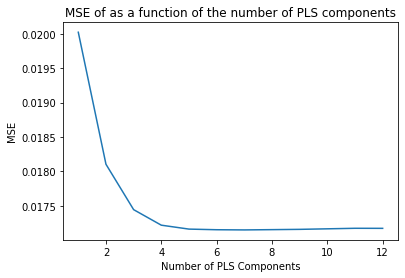

In [337]:
# Get training and test set
X_train,X_test,y_train,y_test = train_test_split(X2,y1,test_size=0.3,random_state=0) 

#define cross-validation method
cv = RepeatedKFold(n_splits=20, n_repeats=3, random_state=1)

mse = []
n = len(X_train)

with warnings.catch_warnings():
    warnings.simplefilter("ignore") #Ignore runtime warning (divide by zero)

    # Calculate MSE using cross-validation, adding one component at a time
    for i in np.arange(1, 13):
        pls = PLSRegression(n_components=i)
        score = -1*model_selection.cross_val_score(pls, scale(X_train), y_train, cv=cv,
                scoring='neg_mean_squared_error').mean()
        mse.append(score)

#plot test MSE vs. number of components
plt.rcParams['figure.facecolor'] = 'white'
plt.plot(np.arange(1,len(mse)+1,1),mse)
plt.xlabel('Number of PLS Components')
plt.ylabel('MSE')
plt.title('MSE of as a function of the number of PLS components')
print(f'The number of PLS components yielding the lowest MSE is: {np.argmin(mse)+1}')

<br> 

<br> 

#### Train and test model performance

In [338]:
#calculate MSE
pls = PLSRegression(n_components=np.argmin(mse)+1)
X_mean = X_train.mean()
X_std = X_train.std()
pls.fit(scale(X_train), y_train)

X_test_std = (X_test-X_mean)/X_std
print(f'The MSE of the test data is {mean_squared_error(y_test, pls.predict(X_test_std.to_numpy())):.4f}')

The MSE of the test data is 0.0187


<br> 

##### Plotting the predicted values

In [339]:
# Extract predictions and test values and sort them according to the predicted values
y_test_dat = y_test.to_numpy().ravel()
y_hat_dat = pls.predict(X_test_std.to_numpy()).ravel()

sort_indx = np.argsort(y_hat_dat)
y_test_sorted = y_test_dat[sort_indx]
y_hat_sorted = y_hat_dat[sort_indx]

# Df for test data and predictions
test_data = pd.DataFrame({'y_test':y_test_sorted,'y_hat':y_hat_sorted, 'y_cont':X1['Continent'].iloc[X_test.index]})
test_data = test_data.reset_index().drop(columns='index')

Text(0.5, 0.95, 'Test data vs. fitted data')

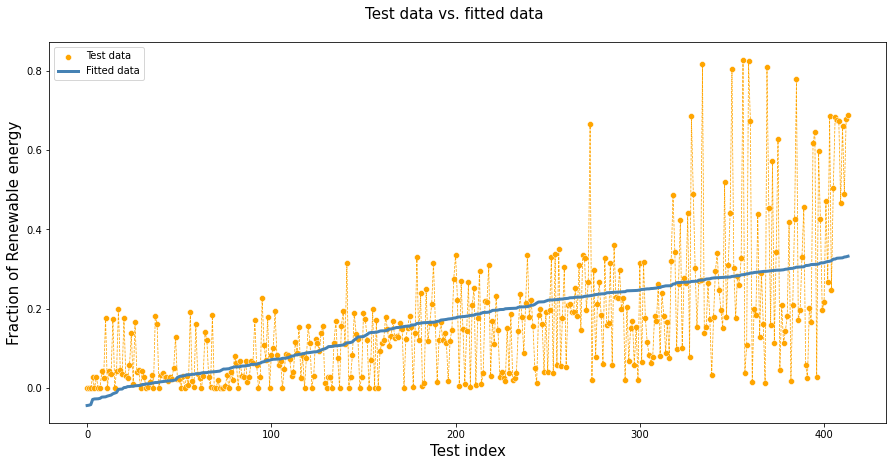

In [340]:
# Plot the results
fig, ax = plt.subplots(1,1,figsize=(15,7))
sns.lineplot(data=test_data, x=test_data.index, y='y_test',ax=ax, linewidth=0.75, color='orange', linestyle='--')
sns.scatterplot(data=test_data,x=test_data.index,y='y_test',ax=ax, color='orange', label='Test data')
sns.lineplot(data=test_data, x=test_data.index, y='y_hat',ax=ax, color='steelblue', linewidth=3, label='Fitted data')
ax.set_ylabel('Fraction of Renewable energy', fontsize=15)
ax.set_xlabel('Test index', fontsize=15)
fig.suptitle('Test data vs. fitted data', fontsize=15, y=0.95)

By no means a perfect model, but it does seem to capture the trend ok. We also have predicted values below zero, which indictaes that the model type is not perfect for this problem (one could have probably looked into *Generalized Linear Models* to solve this issue.)

<br> 

<br> 

#### Find R2 value of model

In [341]:
SSres = np.sum((test_data.y_test-test_data.y_hat)**2)
SStot = np.sum((test_data.y_test-np.mean(test_data.y_test))**2)

R2 = 1-SSres/SStot
print(f'R2 value is: {R2:.3f}')
print(f'The correaltion coefficient between the predicted and test values is: {np.corrcoef(test_data.y_test,test_data.y_hat)[1,0]:.3f}')
print('\n\nThe loadings/correlations between the target variable and the PLS components are')
print(pls.y_loadings_.ravel())

R2 value is: 0.350
The correaltion coefficient between the predicted and test values is: 0.592


The loadings/correlations between the target variable and the PLS components are
[ 0.21471252  0.27201768  0.21305102 -0.10366524  0.06407632  0.0331531
  0.02122158]


Our model is in essence able to describe around 35% of the variance in the target value (so 35% of the variance in the countries different fraction of renewable energy consumption).

<br> 

<br> 

#### Analysis of PLS components

In [325]:
# Extract PLS component loadings and enrich
n_comp = 3

with warnings.catch_warnings():
    warnings.simplefilter("ignore") #Ignore runtime warning (divide by zero)
    loadings=pd.DataFrame(pls.x_loadings_.T)
    loadings.columns = X2.columns

    loadings_v = loadings.unstack().reset_index()
    loadings_v.columns = ['Feature','PLS Component','Loading']

    loadings_v = loadings_v[loadings_v['PLS Component'] < n_comp]
    loadings_v['Continent'] = np.array(['Continent' in x for x in loadings_v['Feature']])
    loadings_v['x'] = np.array([0,0,0,1,1,1,2,2,2,3,3,3,4,4,4,5,5,5,6,6,6,7,7,7,
                                1,1,1,2,2,2,3,3,3,4,4,4,5,5,5,6,6,6])
    loadings_v['PLS Component'] = loadings_v['PLS Component']+1

# Extract social metrics and ohe continents from features
social_feats = pd.Series([x for x in loadings_v['Feature'] if 'Continent' not in x]).unique()
continents = pd.Series([x for x in loadings_v['Feature'] if 'Continent' in x]).unique()
continents = np.array([x.split('_')[1] for x in continents])
loadings_v = loadings_v.reset_index().drop(columns='index')

for indx,feat in enumerate(loadings_v['Feature']):
    if "Continent" in feat:
        loadings_v.loc[indx,'Feature'] = feat.split('_')[1]

Below we have a vizualization of the PLS component loadings (how much each feature is "correlated" with this component). Currently showing results for PLS component 1

In [333]:
comp = 1

fig = px.bar(loadings_v[loadings_v['PLS Component'] == comp], x="x", y="Loading", color="Feature", barmode='group',
             facet_col='Continent', facet_col_wrap=2, color_discrete_map=colormap,
             category_orders={'Continent':[False, True]},
             labels={'x':''},
             width=900, height=350,
             facet_row_spacing = 0.125,
             hover_name="Feature",hover_data={"Loading": True,
                                              "Feature": False,
                                              "Continent": False,
                                              "x":False,
                                              "PLS Component":False})
fig.update_traces(width=0.8)
fig.update_layout(
    xaxis = dict(
        showticklabels=False
    ),
    xaxis2 = dict(
        showticklabels=False
    ),
    xaxis3 = dict(
        showticklabels=False
    )
)
fig.update_layout(xaxis_range=[-1,8])
loads = loadings_v['Loading'][loadings_v['PLS Component'] == comp]
fig.update_layout(yaxis_range=[np.min([np.min(loads)*1.1,-0.1]),np.max(loads)*1.1])
fig.update_yaxes(
        tickvals=[-1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    )

fig.update_layout(
    margin=dict(l=40, r=40, t=40, b=50)
)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=1.05
))

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.2,
    xanchor="right",
    x=1
))
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("Continent=True", "<b>Continents</b>")))
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("Continent=False", "<b>Social metrics</b>")))
    
fig.show()

<br> 
<br> 
<br> 

## **4. Genre**

First of all, we made ues the article/magazine style as our data story type. 

**Visual narrative:**

Visual Structuring:
- We have made a lot of use of the Progress Bar / Timebar in order to show to progress of both energy consumption and social/economic measures over time. We are very much interested in seeing how things progress over time, so this is an ideal tool. 

Highlighting (NB):
- We generally make use of color in order to direct the viewer's attention. We have a plot of the world that tracks fraction of renewables across time. The color grading goes from black (fraction of 0) to saturated green (fraction of 1), which should make the plot more intuitive. 
- We also make use of dropdown menues in order to enable the user to narrow down the information in the plots and focus on the particular things that that user finds interesting. 
- In general, we make quite a lot of use of motion, since, as mentioned earlier, we want to underpin that things are changing quite a lot over time. For instance, the fraction of renewables vs social/economic metric (the one with the blobs) has a lot of motion in it. 

Transition Guidance:
- Since we decided to use a article/magazine style, we do not have transitions in a regular sense. The user will simply scroll down through the article, so the focus in terms of transition are on the ordering of the visuals and of the information. 
- Additionally, in order to within or between visual scenes, we use quite a few dropdown menues and check-boxes. This might not be transitions in a regular sense, but it is the closest we have to it. 

**Narrative Structure:**

Ordering:
- We make use of a linear ordering, suited to the magazine style. We do, however, also want to let the user do some exploration on their own, so we use dropdown menues and checkboxes. 

Interactivity:
- Most figures have quite a lot of interaction. As mentioned earlier, we have both dropdown and checkboxes, and we also have information that pops up on hover-over. 
- Using the interactivity in the figures is very intuitive and straight-forward, so tutorials are not necessary. We have generally selected default views that make sense. In general, people are much more used to interaction than they might have been, so hand-holding is not as necessary. 

Messaging:
-  In general, we use a lot of annotations in order to communicate information to the user. A great example is the figure for the PLS model, where one can toggle between the components that each have a specific textbox attached to it. 
- Since we use the article/magazine style, there is naturally a lot of messaging, which means that we also use tools like intoductory text and Summary / Synthesis.




<br> 
<br> 
<br> 

## **5. Visualizations**

### **Fraction of renewable energy across time**

**Explanation of this visual**:

This is a rather simple line plot of the fraction of renewable energy vs time on a continent level. The fraction is calculated as the consumption stemming from renewables devided total energy consumption, thus giving a value between 0 and 1. The average of the continents is shown as global. 

<br>

**Why is this right for our story**:
We use this as an "introduction" to the problem. It is a figure that is easy to understand and digest, while it still shows some interesting phenomena, which mandates further and deeper analysis. We use this graph only looking at energy consumption first, since our aim is to first show that some interesting things is going on here. We then go on to analyze it in combination with social/economic metrics. At the end of the day, is is the right figure since it tells the centerpoint of our problem in the simplest way possible. The idea is therefore to abstract away all the smaller details and look at overall trends. The smaller details can then be added in the following plots. 



In [ ]:
fig = px.line(plot_data, 
    x="Year", y="Fraction of Low-carbon energy per capita", 
    color="Continent", width=800, height=500, 
    title="Fraction of renewable energy across time", 
    labels={"Year": "Year", "Fraction of Low-carbon energy per capita": "Fraction of renewable energy"})
fig.show()

### **Energy measures across time (and fraction of renewables)**

**Explanation of this visual**:

In this plot, we see a world map that varies with time. In the dropdown menu, one can choose different energy types. When you press play, a video starts showing the change of that particular energy type with time. The map is then colored at the country level, e.g. showing the coal consumption per capita across the globe. In order to see differences between countries, they are colored according to the heat-map to the right. As mentioned, this can be done for the different energy types, but it can also be done for fraction of renewable energy, which is our main point of interest in terms of energy in this project. 

<br>

**Why is this right for our story**:

This is really useful for the story we want to tell, since we want to gain some insight into differences in energy consumption across the globe. Adding the time dimension gives some interesting and intuitive insight into the patterns and developments across time. Additionally, it is at the granularity level of the raw data, so this is way in which we can extract as much information as possible. The interactiveness is useful since it is a way for us to let the user do some exploration on our own and make their own observations. The plot is also nice since it really does show that there are quite a lot of difference in consumption from country to country, so it works as a nice transition into looking at the relationship between energy consumption and social/economic measures. Another nice biproduct of the figure is that we can easily see that we have limitations in terms of data: many of the countries are not represented until much later in time. Thus, in many ways, the figure is an integral part of our visual narrative, combining most of the elements mentioned in “5. Genre”, using Progress Bar / Timebar etc. It is also integrated in our narrative structure, where we here focus a lot on the interactivity. 

### **Relationship between energy and social/economic measures**

**Explanation of this visual**:

The main idea this plot is to allow the reader to explore the relationsships between the social/economic measures and the fraction of renewables one-by-one. This visual has the possibility to either reduce or add "complexity" in terms of information for the different meassures, in order to allow for both deeper and more shallow understanding of the relationship. We allow the user to explore the relationship across time interactively, this way both allowing the user to "play around" with the data in his/her own way, but also making it possible to capture time-variying relations. 

On the webside, we will provide the user with just a few "interesting" cases to study (in bullet-form), to both guide the user towards some of the more interesting relations, that we found, but also get familiar with the navigating the visual. This type of visual follows more of a visual narative, with little to no hand-holding.

<br>

**Why is this right for our story**:

We choose a plot like this, because the type of plot (together with frames/progression bar and trendlines), can capture quite a lot of information in a relatively simple figure. The relationship between multidimensional social data and the fraction of renewable is inherently very difficult to capture, without getting the sense of information overload. Thus we choose to allow for only single social measure comparisons, but with the addon of continent by color and population by size, which still gives the plots a natural look. 

Still, after exploring the social measures one-by-one, one might still get the feeling, that there is a lot of underlying structure, that we do not manage to visualize in plots like this. This naturally leads towards ML models, which can help us understand some of these more latent/complex structures. 

##### Short data prep

In [ ]:
data_energy = energy_data.set_index(["Entity", "Continent", "Year"])
data_social = social_data.set_index(["Entity", "Continent", "Year"])

df_social_energy = data_energy.join(data_social, how="outer").reset_index()
df_social_energy = (
    df_social_energy.sort_values(["Year", "Entity"]).reset_index().drop(columns="index")
)
df_social_energy["Fraction of Low-carbon energy per capita"] = (
    df_social_energy["Low-carbon energy per capita (kWh)"]
    / df_social_energy["Energy per capita (kWh)"]
)
col_int = [
    "GDP per capita ($)",
    "Child mortality rate (under 5 years - %)",
    "HDI",
    "Life expectancy (years)",
    "Population",
    "Tertiary education (%)",
    "Internet users (%)",
    "Tax revenue of total GDP (%)",
]
df_social_energy = (
    df_social_energy.sort_values(["Year", "Continent", "Entity"])
    .reset_index()
    .drop(columns="index")
)


##### Plot

In [ ]:
####################################
#### Interactive on webside: #######
####################################

# Add/remove visual tools (Tick on/off bottoms)
values = ['Continent', 'Scatter'] #Include scatter, continent, trendline by adding them to values

#Choose comparison measure (Dropdown menu)
x = "HDI" #choose between 
          # 'GDP per capita ($)', 'Child mortality rate (under 5 years - %)', 'Population', 'HDI',
          # 'Life expectancy (years)', 'Tertiary education (%)','Internet users (%)',
          # 'Tax revenue of total GDP (%)'

####################################
####################################

y = "Fraction of Low-carbon energy per capita"
df_int = (
    df_social_energy.iloc[
        np.sum(np.array(df_social_energy[[x, y]].isnull()) * 1.0, axis=1) == 0
    ]
    .reset_index()
    .drop(columns="index")
)

if x == "Population":
    log_axis = True
else:
    log_axis = False

for i in np.sort(df_int["Year"].unique()):
    if len(df_int["Continent"][df_int["Year"] == i].unique()) != 6:
        df_int = df_int[df_int["Year"] != i].reset_index().drop(columns="index")
    else:
        break;

if "Continent" in values:
    color = "Continent"
    trendline_color = None
else:
    color = None
    trendline_color = "Black"

if "Scatter" in values:
    df_int["size"] = df_int["Population"] ** (1 / 2)  # "Energy per capita (kWh)"
    size_max = 40
else:
    df_int["size"] = df_int[x] * 0 + 0.001
    size_max = 0.001

if "Trendline" in values:
    scope = "trace"
    type = "lowess"
    frac = 0.75
else:
    scope = "trace"
    type = None
    frac = None

fig1 = px.scatter(
    df_int,
    x=x,
    y=y,
    size="size",
    color=color,
    animation_frame="Year",
    animation_group="Entity",
    log_x=log_axis,
    size_max=size_max,
    range_x=[np.min(df_int[x]), np.max(df_int[x]) * 1.1],
    range_y=[-0.2, 1.2],
    labels={y: "Fraction of Renewable Energy ", x: x},
    trendline_scope=scope,
    trendline=type,
    trendline_options=dict(frac=frac),
    trendline_color_override=trendline_color,
    hover_name="Entity",
    hover_data={"Continent": True, "Year": False, x: True, y: True, "size": False},
)

fig1.update_layout(margin={"t": 0, "l": 0, "r": 0, "b": 0})
fig1.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 200
fig1.add_hline(y=1, line_width=1, line_dash="dash", line_color="gray")
fig1.add_hline(y=0, line_width=1, line_dash="dash", line_color="gray")

if ("Trendline" not in values) & ("Scatter" not in values):
    fig1.add_annotation(
        x=1 / 2 * (np.max(df_int[x]) * 1.1 - np.min(df_int[x])),
        y=0.5,
        text="Choose either Scatter or Trendline to show data",
        font=dict(family="Courier New, monospace", size=16, color="Black"),
        align="center",
        bordercolor="Black",
        borderwidth=2,
        borderpad=4,
        bgcolor="#ADD8E6",
        showarrow=False,
        opacity=0.8,
    )

fig1.show()

### **PLS Component analysis**

**Explanation of this visual**:

The main idea this plot is to provide the reader with an overview of the results from the ML model, presented in a way that both allows people with little understanding of the specific ML model to understand, what the results show, but also using some of the 'correct' terminology for the more ML advanced readers. We provide a small annotated description of PLS components we found, mainly translating (or help grasping) what these PLS components actually tells us. Here we want to show the main results of the ML model, thus only providing the visuals/annotations for the first 3 PLS components, both because these were the most significant ones, but also because we did not want to pass on too many conclusion for the reader (they might end up loosing track of what was really important). 

In this visual we do not allow the user to "play around" with the plot, but use more of a narative structure to really put emphasis on the results of our analysis.

<br>

**Why is this right for our story**:

This is the plot where we present the final results of our analysis, so this visual should, hopefully, close up the loose ends of the article. We thus should not allow for too much interpretation for the reader, but rather tell the reader, what he/she should take away from this - a lot of hand-holding. This visual is a way to provide the user with our results in both a visual and descriptive form, hopefully making it easier to grasp. 

##### Plot

In [334]:
comp = 1 #PLS component

fig = px.bar(loadings_v[loadings_v['PLS Component'] == comp], x="x", y="Loading", color="Feature", barmode='group',
             facet_col='Continent', facet_col_wrap=2, color_discrete_map=colormap,
             category_orders={'Continent':[False, True]},
             labels={'x':''},
             width=900, height=600,
             facet_row_spacing = 0.125,
             hover_name="Feature",hover_data={"Loading": True,
                                              "Feature": False,
                                              "Continent": False,
                                              "x":False,
                                              "PLS Component":False})
fig.update_traces(width=0.8)
fig.update_layout(
    xaxis = dict(
        showticklabels=False
    ),
    xaxis2 = dict(
        showticklabels=False
    ),
    xaxis3 = dict(
        showticklabels=False
    )
)
fig.update_layout(xaxis_range=[-1,8])
loads = loadings_v['Loading'][loadings_v['PLS Component'] == comp]
fig.update_layout(yaxis_range=[np.min([np.min(loads)*1.1,-0.1]),np.max(loads)*1.1])
fig.update_yaxes(
        tickvals=[-1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    )

fig.update_layout(
    margin=dict(l=40, r=40, t=40, b=300)
)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=1.05
))

if comp == 1:
    anno_text = str(f'<b>PLS Component 1</b><br><br>'+
                    f'The correlation coefficient with the target variable is: <b>{pls.y_loadings_[0][0]:.3f}' + 
                    '</b><br><br>For the continents, we see that it '+
                    '<b>positively</b> correlates with <b>Europe</b>, while<br>'+ 
                    'it <b>negatively</b> correlates with <b>Asia</b>. For '+
                    'the social/economic metrics, we see<br>'+
                    'high <b>positive</b> loadings in measures '+
                    'related do <b>high development</b>, while we<br>'+
                    'have <b>negative</b> correlation for <b>child '+
                    'mortality</b> and <b>population</b>. It seems like<br>'+
                    'this component captures <b>European</b> countries '+
                    'that are <b>highly developed</b> and puts it in<br>'+
                    'opposition to <b>Asian</b> countries. <br><br>'+
                    'An example of such a country could be '+
                    '<b>Iceland.</b>')

elif comp == 2:
    anno_text = str(f'<b>PLS Component 2</b><br><br>'+
                    f'The correlation coefficient with the target variable is: <b>{pls.y_loadings_[0][1]:.3f}' + 
                    '</b><br><br>Looking at the continents, we see that '+
                    'this component seems to represent <b>South<br>'+ 
                    'American</b> countries, putting it in '+
                    'opposition to <b>Asia</b>. For the social/economic<br>'+
                    'measures, we see something interesting. '+
                    'Despite the component correlating<br>'+
                    '<b>positively</b> with the response, we have '+
                    '<b>negative</b> correlations for many of the<br>'+
                    'measures. This seems to suggest that '+
                    'the <b>South American</b> can have a relatively<br>'+
                    '<b>high fraction of renewables</b> despite '+
                    'scoring low in the social/economic domain.<br><br>'+
                    'A good example of this situation is <b>Brazil</b>.')

else:
    anno_text = str(f'<b>PLS Component 3</b><br><br>'+
                    f'The correlation coefficient with the target variable is: <b>{pls.y_loadings_[0][2]:.3f}' + 
                    '</b><br><br>Here, it looks like the component '+
                    'are very <b>populous</b> and are <b>relatively,<br>'+
                    'developed</b> while also somewhat' +
                    'representing <b>Oceania</b>. It also seems<br>'+
                    'like <b>African</b> countries (in particular) ' +
                    'in this component show the opposite <br>'+
                    'trend than the <b>Asian</b> ones.<br><br>'+
                    'An example of a country that fits '+
                    'this description is <b>China</b>.')

                    
                      
                      
                       
                     

fig.add_annotation(
    yanchor="top",
    xanchor="left",
    yref = 'paper',
    xref = 'paper',
    x=0,
    y=-0.15,
    text=anno_text,
    font=dict(family="Courier New, monospace", size=16, color="Black"),
    align="left",
    bordercolor=None,
    borderwidth=1,
    borderpad=4,
    bgcolor="#EBECF0",
    showarrow=False,
    opacity=0.8,
)
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.2,
    xanchor="right",
    x=1
))
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("Continent=True", "<b>Continents</b>")))
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("Continent=False", "<b>Social metrics</b>")))
    
fig.show()

<br> 
<br> 
<br> 

## **6. Discusion**

The plots we have created do a good job of telling the story that we want. The combination of an article with some interactive plots strikes a nice balance between finding a story that we want to tell, while also allowing the user to do some exploration on their own. The plots are in general also quite packed with information, but we think we have done a decent job of presenting that information in a way that makes it digestable. We have also managed to extract meaningful information about the problem, while not over-analyzing and jumping to conclusions that are not justified. At it's core, it is a very complex problem, and our analysis is off course not even close to definitive and complete. 

Things brings us to some of the short-comings of our creation. We got the impression from the litterature that there are other types of models that are often used for these kinds of problems, but we did not find the time to investiate and understand them. Thus, one avenue for improvement is looking more thoroughly into modelling approaches. One thing that is also clear from our analysis is that there is a lot of individuality from country to country. It can therefore be hard to really draw general conclusions. For example, Brazil does not score highly in most of the social/economic measures, but they have a relatively high fraction of renewables[*3*], which might be contrary to what our initial hypothesis was. On the other hand, we have country like the US, where the opposite is true. This goes to show that there are certain limitations to analyzing this problem quantitatively and that it is important to understand the specific circumstances of a country. One could argue that this could also be encoded, and thus modelled quantitatively, but that would require a much larger and more time-consuming analysis. 

<br> 
<br> 
<br> 

## **7. Contributions**

- **1. Motivation**: *ST37*
- **2. Basic stats**
    - **Data cleaning and preprocessing**: *ST150*
    - **Datasets stats and exploratory analysis**: *ST150*
- **3. Data analysis**
    - **Initial Data analysis**: *ST37*, *ST150*
    - **Machine learning algorithm (PLS)**: *ST150*
- **4. Genre**: *ST37*
- **5. Vizualizations**
    - **Fraction of renewables across time**: *ST37*
    - **Energy measures across time (and fraction of renewables)**: *ST173*
    - **Relationship between energy and social/economic measures**: *ST150*
    - **PLS Component analysis**: *ST150*, *ST37*
- **6. Discussion**: *ST37*

<br>

- **Homepage setup**: *ST173*
- **Homepage**
    - **Past, Present and future of energy**
        - **Text**:
        - **Visualization**: *ST173*
    - **Exploring relationship between energy and social/econimic measures**
        - **Text**: *ST150*, *ST37*
        - **Visualization**: *ST150*
    - **Modelling relationship between energy and social/economic measures**
        - **Text**: *ST37*
        - **Visualization**: *ST150*, *ST37*
    - **From results to broader perspective**:
    


<br> 
<br> 
<br> 

## **8. References**

- [United Nations Climate Change conference *(1)*](https://en.wikipedia.org/wiki/United_Nations_Climate_Change_conference)
- [Partial Least Squares *(2)*](https://en.wikipedia.org/wiki/Partial_least_squares_regression)
- [Climate score card *(3)*](https://www.climatescorecard.org/2021/01/brazil-sources-45-of-its-energy-from-renewables/)